### Pacman DQN vs DDQN

In [3]:
import random
import tkinter as tk
from tkinter import Canvas
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import deque
from datetime import datetime
import copy
import time

#### Utility Functions (Statistics, Time formating, Data exporting)

In [1]:
def sum_rewards(reward_per_episode, episodes_completed):
    """Returns the reward for last 100 episodes for each episode, to give the success rate of the algorithm."""
    sum_of_rewards = np.zeros(episodes_completed)
    for i in range(episodes_completed):
        # Rewards for last 100 episodes
        sum_of_rewards[i] = np.sum(reward_per_episode[max(0, i - 100):(i+1)])

    return sum_of_rewards

def cumulative_reward(rewards_per_episode):
    """Create a list of the cumulative reward the agent has gained per episode."""
    cumulative_reward = [rewards_per_episode[0]]
    for i in rewards_per_episode[1:]:
        cumulative_reward.append(i + cumulative_reward[-1])
        
    return cumulative_reward

def one_in_x(a_list, x):
    """Returns every one in x of a given list for purpose of smoothing reward graphs."""
    return a_list[::x]

def format_time(seconds):
    """Formats time in seconds into hours/minutes/seconds and returns a string of the resulting time."""
    minutes = int(seconds // 60)
    hours = int(minutes // 60)
    minutes = minutes % 60
    seconds = seconds % 60
    if hours > 0:
        return f"{hours} hours, {minutes} minute{'s' if minutes != 1 else ''}, {seconds:.2f} seconds"
    if minutes > 0:
        return f"{minutes} minute{'s' if minutes != 1 else ''}, {seconds:.2f} seconds"
    return f"{seconds:.2f} seconds"

def export_results(rewards, violations):
    """Function to export results to an Excel file."""
    # Create Pandas datafram to hold results
    to_save = pd.DataFrame({"Rewards": rewards, "Violations": violations})
   
    # Export the DataFrame to Excel.
    writer = pd.ExcelWriter("Results_" + datetime.now().strftime('%d.%m.%Y_%H.%M') + '.xlsx', engine='xlsxwriter')
    to_save.to_excel(writer, sheet_name='Sheet1', index=False)
    writer.close()
    print("Save sucessful")

### Deep Q-Learning

In [5]:
class ExperienceReplay():
    """Class to store experiences for training purposes.
       Experiences are store in the format (current_state, action, new_state, reward, terminated)"""
    def __init__(self, memory_max=500000, batch_size=32):
        self.memory = deque([], maxlen=memory_max) # Maximum experiences stored
        self.batch_size = batch_size # Batch size
    
    def add_experience(self, exp):
        # Adds an experience to replay buffer.
        # Format (current_state, action, new_state, reward, terminated)
        self.memory.append(exp)
    
    def sample(self):
        # Returns a batch of samples from memory.
        return random.sample(self.memory, self.batch_size)
    
    def current_memories(self):
        # Returns how many memories are currently stored.
        return len(self.memory)


class DQN(nn.Module):
    """Class for the network model."""
    def __init__(self, in_states, out_actions):
        super().__init__()

        # Define network layers
        self.fc1 = nn.Linear(in_states, 32) 
        self.fc2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, out_actions)

    def forward(self, x):
        # Forward pass through the network.
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.out(x)
        return x

class CoordinateMemory():
    # Class to store coordinates explored for exploration bonus purposes.
    def __init__(self):
        # Ititialise a set with Pacmans starting coordinates.
        self.memory = set((1, 1))
    
    def add(self, pos):
        # Adds an explored coordinate to memory and returns if it is newly explored.
        pos = tuple(pos)
        new = True # Is the coordinate newly explored, or not.
        if pos in self.memory:
            new = False
        self.memory.add(pos)
        
        return new

In [77]:
# Simple Pacman Map
# 1 = wall, 2 = food, 0 = empty space
INITIAL_MAZE = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1],
    [1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1],
    [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1],
    [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1],
    [1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
    [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
    [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
    [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
]

# Directions for movement, including Stop
directions = {
    "North": [-1, 0],
    "South": [1, 0],
    "East": [0, 1],
    "West": [0, -1],
    "Stop": [0, 0]
}

# Relative directions for right-hand and left-hand rules
RIGHT_TURN = {
    "North": "East",
    "East": "South",
    "South": "West",
    "West": "North"
}

LEFT_TURN = {
    "North": "West",
    "West": "South",
    "South": "East",
    "East": "North"
}

OPPOSITE = {
    "North": "South",
    "South": "North",
    "East": "West",
    "West": "East"
}

# Game Settings
CELL_SIZE = 30
WINDOW_SIZE = len(INITIAL_MAZE) * CELL_SIZE
WALL_THICKNESS = 4
WALL_GAP = 2

# Ghost movement probability
GHOST_MOVE_PROBABILITY = 0.9


class WallFollowingGhost:
    """Class for the wall following ghosts movement policy. Largely generated by Grok 3
       Can be set to follow the left or right wall.
       
       Input: Colour, starting position, starting direction and follow side."""
    def __init__(self, color, start_pos, start_direction, follow_side="right"):
        self.color = color
        self.current_pos = start_pos
        self.direction = start_direction
        self.follow_side = follow_side

    def move(self, maze):
        row, col = self.current_pos
        if self.follow_side == "right":
            # Follow side is left.
            turn_dir = RIGHT_TURN[self.direction]
            straight_dir = self.direction
            left_dir = LEFT_TURN[self.direction]
            back_dir = OPPOSITE[self.direction]
            directions_to_try = [turn_dir, straight_dir, left_dir, back_dir]
        else:
            # Follow side is left
            turn_dir = LEFT_TURN[self.direction]
            straight_dir = self.direction
            right_dir = RIGHT_TURN[self.direction]
            back_dir = OPPOSITE[self.direction]
            directions_to_try = [turn_dir, straight_dir, right_dir, back_dir]

        for direction in directions_to_try:
            delta_row, delta_col = directions[direction]
            new_row = row + delta_row
            new_col = col + delta_col
            if (0 <= new_row < len(maze) and 0 <= new_col < len(maze[0]) and
                    maze[new_row][new_col] != 1):
                self.current_pos = [new_row, new_col]
                self.direction = direction
                break


class PacmanGame:
    """Class to handle and draw the Pacman game enviroment. Largely generated by Grok 3."""
    def __init__(self, root, num_ghosts=1, visualize=True):
        self.visualize = visualize
        self.root = root if visualize else None
        if visualize:
            self.canvas = Canvas(self.root, width=WINDOW_SIZE, height=WINDOW_SIZE, bg="black")
            self.canvas.pack()
        self.num_ghosts = max(1, min(4, num_ghosts))
        self.ghost_colors = ["red", "pink", "orange", "cyan"][:self.num_ghosts]
        self.ghost_start_positions = [[3, 5], [3, 10], [11, 4], [11, 10]][:self.num_ghosts] # Also set in self.ghosts
        self.ghosts = [
            # Red ghost (Blinky)
            WallFollowingGhost("red", [3, 5], "South", follow_side="right"),
            # Pink ghost (Pinky)
            WallFollowingGhost("pink", [3, 10], "South", follow_side="left"),
            # Orange ghost (Clyde)
            WallFollowingGhost("orange", [11, 4], "North", follow_side="right"),
            # Cyan ghost (Inky)
            WallFollowingGhost("cyan", [11, 10], "North", follow_side="left")
        ][:self.num_ghosts]
        self.ghost_positions = [ghost.current_pos for ghost in self.ghosts]
        self.ghost_modes = ["wall_following"] * self.num_ghosts
        self.state_size = 2 + 2 * self.num_ghosts
        self.action_size = 4
        self.actions = ["North", "South", "East", "West"] # Available actions
        self.reset_episode()

    def reset_episode(self):
        self.maze = [row[:] for row in INITIAL_MAZE]
        self.pacman_pos = [1, 1]  
        for i, ghost in enumerate(self.ghosts):
            ghost.current_pos = self.ghost_start_positions[i]
            if ghost.color == "red":
                ghost.current_pos = [3, 4]
                ghost.direction = "South"
            elif ghost.color == "pink":
                ghost.current_pos = [3, 10]
                ghost.direction = "South"
            elif ghost.color == "orange":
                ghost.current_pos = [11, 4]
                ghost.direction = "North"
            elif ghost.color == "cyan":
                ghost.current_pos = [11, 10]
                ghost.direction = "North"
        self.ghost_positions = [ghost.current_pos for ghost in self.ghosts]
        self.food_left = sum(row.count(2) for row in self.maze)  # Count only initial 2s
        self.running = True
        self.pacman_direction = "East"
        self.ghost_modes = ["wall_following"] * self.num_ghosts
        if self.visualize:
            self.draw_maze()
            self.draw_pacman()
            self.draw_ghosts()

    def draw_maze(self):
        if not self.visualize:
            return
        self.canvas.delete("all")
        rows, cols = len(self.maze), len(self.maze[0])
        for row in range(rows):
            for col in range(cols):
                x1, y1 = col * CELL_SIZE, row * CELL_SIZE
                x2, y2 = x1 + CELL_SIZE, y1 + CELL_SIZE
                if self.maze[row][col] == 2:
                    self.canvas.create_oval(x1 + 12, y1 + 12, x2 - 12, y2 - 12, fill="white")
                elif self.maze[row][col] == 1:
                    if row == 0 or self.maze[row-1][col] != 1:
                        self.canvas.create_line(x1, y1, x2, y1, fill="blue", width=WALL_THICKNESS)
                        self.canvas.create_line(x1, y1 + WALL_GAP, x2, y1 + WALL_GAP, fill="blue", width=WALL_THICKNESS)
                    if row == rows - 1 or self.maze[row+1][col] != 1:
                        self.canvas.create_line(x1, y2, x2, y2, fill="blue", width=WALL_THICKNESS)
                        self.canvas.create_line(x1, y2 - WALL_GAP, x2, y2 - WALL_GAP, fill="blue", width=WALL_THICKNESS)
                    if col == 0 or self.maze[row][col-1] != 1:
                        self.canvas.create_line(x1, y1, x1, y2, fill="blue", width=WALL_THICKNESS)
                        self.canvas.create_line(x1 + WALL_GAP, y1, x1 + WALL_GAP, y2, fill="blue", width=WALL_THICKNESS)
                    if col == cols - 1 or self.maze[row][col+1] != 1:
                        self.canvas.create_line(x2, y1, x2, y2, fill="blue", width=WALL_THICKNESS)
                        self.canvas.create_line(x2 - WALL_GAP, y1, x2 - WALL_GAP, y2, fill="blue", width=WALL_THICKNESS)

    def draw_pacman(self):
        """Function to draw the Pacman in the Pacman game. Generated by Grok 3"""
        if not self.visualize:
            return
        row, col = self.pacman_pos
        x, y = col * CELL_SIZE + CELL_SIZE // 2, row * CELL_SIZE + CELL_SIZE // 2
        radius = CELL_SIZE // 2 - 2
        if self.pacman_direction == "East":
            start, extent = 30, 300
        elif self.pacman_direction == "West":
            start, extent = 210, 300
        elif self.pacman_direction == "North":
            start, extent = 120, 300
        else:
            start, extent = 300, 300
        self.pacman = self.canvas.create_arc(
            x - radius, y - radius, x + radius, y + radius,
            start=start, extent=extent, fill="yellow", outline="yellow"
        )

    def draw_ghosts(self):
        """Function to draw the ghots in the Pacman game. Generated by Grok 3"""
        if not self.visualize:
            return
        self.ghosts_drawn = []
        for i, ghost in enumerate(self.ghosts):
            row, col = ghost.current_pos
            x, y = col * CELL_SIZE + CELL_SIZE // 2, row * CELL_SIZE + CELL_SIZE // 2
            radius = CELL_SIZE // 2 - 2
            points = []
            num_points = 10
            for j in range(num_points + 1):
                angle = np.pi * j / num_points
                px = x - radius * np.cos(angle)
                py = y - radius * np.sin(angle)
                points.append(px)
                points.append(py)
            points.extend([
                x + radius, y + radius - 5,
                x + radius * 0.75, y + radius,
                x + radius * 0.25, y + radius - 5,
                x - radius * 0.25, y + radius,
                x - radius * 0.75, y + radius - 5,
                x - radius, y + radius - 5,
                x - radius, y
            ])
            body = self.canvas.create_polygon(points, fill=ghost.color, outline=ghost.color, smooth=True)
            eye_radius = radius // 3
            pupil_radius = eye_radius // 2
            eye_y_offset = y - radius * 0.5
            self.canvas.create_oval(x - radius * 0.5 - eye_radius, eye_y_offset - eye_radius,
                                    x - radius * 0.5 + eye_radius, eye_y_offset + eye_radius,
                                    fill="white")
            self.canvas.create_oval(x + radius * 0.5 - eye_radius, eye_y_offset - eye_radius,
                                    x + radius * 0.5 + eye_radius, eye_y_offset + eye_radius,
                                    fill="white")
            self.canvas.create_oval(x - radius * 0.5 - pupil_radius, eye_y_offset - pupil_radius,
                                    x - radius * 0.5 + pupil_radius, eye_y_offset + pupil_radius,
                                    fill="black")
            self.canvas.create_oval(x + radius * 0.5 - pupil_radius, eye_y_offset - pupil_radius,
                                    x + radius * 0.5 + pupil_radius, eye_y_offset + pupil_radius,
                                    fill="black")
            self.ghosts_drawn.append(body)

    def get_legal_directions(self, pos):
        legal_directions = []
        for direction, (delta_row, delta_col) in directions.items():
            if direction == "Stop":
                continue
            new_row = pos[0] + delta_row
            new_col = pos[1] + delta_col
            if 0 <= new_row < len(self.maze) and 0 <= new_col < len(self.maze[0]) and self.maze[new_row][new_col] != 1:
                legal_directions.append(direction)
        return legal_directions

    def move_ghost(self, ghost_idx, ghost_pos):
        if random.random() > GHOST_MOVE_PROBABILITY:
            return
        if ghost_idx >= self.num_ghosts:
            return

        self.ghosts[ghost_idx].move(self.maze)
        self.ghost_positions[ghost_idx] = self.ghosts[ghost_idx].current_pos

    def move_pacman(self, action):
        """Function to control the agents movemnets on the grid when an action is given."""
        delta_row, delta_col = directions[action]
        new_row = self.pacman_pos[0] + delta_row
        new_col = self.pacman_pos[1] + delta_col
        reward = 0
        if action != "Stop":
            self.pacman_direction = action
        if 0 <= new_row < len(self.maze) and 0 <= new_col < len(self.maze[0]) and self.maze[new_row][new_col] != 1:
            self.pacman_pos[0] = new_row
            self.pacman_pos[1] = new_col
            if self.maze[new_row][new_col] == 2:
                self.maze[new_row][new_col] = 0
                self.food_left -= 1
                reward = 1 # Reward for collecting food
        return reward


    def get_state(self):
        """Function to return a Tensor of the state of the environment.
           This is in the format of pacmans coordinates, then each ghosts coordinates,
           then if two pieces of food are present.  Written by PBN"""
        observations = [] # The state to be returned
        
        # Add Pacmans's x and y coordinates.
        observations.append(self.pacman_pos[1]/14) # Pacmans's X position
        observations.append(self.pacman_pos[0]/6) # Pacmans's Y position
        # Add each Ghost's x and y coordinates. Normalised (with /14 and /6).
        for i, ghost_pos in enumerate(self.ghost_positions):
            observations.append(ghost_pos[1]/14)
            observations.append(ghost_pos[0]/6)
        # Add if each food is still present.
        if self.maze[3][7] == 2:
            observations.append(1) # Piece of food 1
        else:
            observations.append(0)
        if self.maze[1][12] == 2:
            observations.append(1) # Piece of food 2
        else:
            observations.append(0)


        return torch.FloatTensor(observations)

    def step(self, action):
        """Function to perform one step in the environment with the givven action.
           The position of the agent (Pacman) and the hazards (Ghosts) is updated.
           The status of any eaten food is also updated."""
        if self.running:
            reward = self.move_pacman(action) # Reward if food is eaten.
            for idx, ghost_pos in enumerate(self.ghost_positions):
                self.move_ghost(idx, ghost_pos)

            new_state = self.get_state()
            terminated = False
            if any(self.pacman_pos == ghost_pos for ghost_pos in self.ghost_positions):
                # Check if Pacman is in the same position as any ghosts.
                self.running = False
                terminated = True
            elif self.food_left == 0:
                # If food left is zero, Pacman has won the game.
                self.running = False
                terminated = True

            if self.visualize:
                self.draw_maze()
                self.draw_pacman()
                self.draw_ghosts()

        return new_state, reward, terminated


def run_episodes(num_episodes, num_ghosts=1, visualize=True, move_limit=100, random_actions=False, DDQN=False):
    # Training using the Pacman environment by Grok 3 with DQN/DDQN network.
    total_start_time = time.time()
    epsilon = 1 # E-greedy starting policy, starting at 100% randomised movement.
    decay = 0.0001 # Epsilon decay per episode [0.0001=10,000 episodes]
    root = tk.Tk() if visualize else None
    if visualize:
        root.title(f"Pac-Man with {num_ghosts} Ghost(s)")
    game = PacmanGame(root, num_ghosts, visualize)
    actions = ["North", "South", "East", "West"]
    
    # Statistics
    violations = 0 # Safety violations.
    timeouts = 0 # Amount of time the move limit is hit.
    reward_per_episode = []
    violations_per_episode = []
    
    # DQN
    loss_function = nn.MSELoss()
    memory = ExperienceReplay()
    discount_factor = 0.9 # The % of the reward that is propagated back to the the previous state.
    learning_rate = 0.001 # Learning rate for DQN.
    network_sync_rate = 100 # The rate at which the policy and target networks syncronise.
    
    input_len = 8
    num_actions = 4
    memory = ExperienceReplay()
    step_count = 0 # Steps between each target network update.

    # Create policy and target network
    policy_dqn = DQN(in_states=input_len, out_actions=num_actions)
    target_dqn = DQN(in_states=input_len, out_actions=num_actions)
    
    target_dqn.load_state_dict(policy_dqn.state_dict()) # Copy target networks weights from policy network.
    
    optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=learning_rate) # Set Adam optimizer.
    
    def optimize(mini_batch, policy_dqn, target_dqn):
        # Function to perform one training step.
        current_q_list = [] # List of current calculated q values.
        target_q_list = [] # List of target q values.

        for state, action, new_state, reward, terminated in mini_batch:
            if reward != 0 or terminated:
                target = torch.FloatTensor([reward])
            else:
                # Calculate Q value using Double DQN Algorithm.
                # Get best action from the policy network.
                if DDQN:
                    best_action = policy_dqn(state).argmax()
                    with torch.no_grad():
                        target = torch.FloatTensor(reward + discount_factor * target_dqn(new_state)[best_action])
                else: 
                    # Calculate Q value for DQN.
                    with torch.no_grad():
                        target = torch.FloatTensor(reward + discount_factor * target_dqn(new_state).max())
        
            # Get the current set of Q values
            current_q = policy_dqn(state)
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_dqn(state)
            target_q[action] = target
            target_q_list.append(target_q)
        
        # Compute loss for the whole minibatch
        loss = loss_function(torch.stack(current_q_list), torch.stack(target_q_list))
        
        # Optimize the model
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()
        optimizer.step()
        
    
    for episode in range(1, num_episodes + 1):
        # Train for required number of episodes.
        steps = 0
        total_reward = 0

        # Exploration Bonus Coordinate Storage
        exp_memory = CoordinateMemory()
        
        if (episode) % 50000 == 0:
            this_time = time.time()
            print(f"Time {format_time(time.time() - total_start_time)} Starting Episode {episode}...")
            
        game.reset_episode() # Reset environment to initial state.  
        state = game.get_state() # Get initial game state.
        while game.running:
            if random.uniform(0, 1) > epsilon and not random_actions:
                # Select best action
                with torch.no_grad():
                    action_ind = policy_dqn(state).argmax().item()
                    action = actions[action_ind]
            else:
                # Random action
                action = random.sample(actions, 1)[0]
            
            # Take action
            new_state, reward, terminated = game.step(action)
            
            new_exploration = exp_memory.add(game.pacman_pos)
            if new_exploration:
                # Extra reward is new coordinates explored.
                reward += 0.1

            total_reward += reward
            
            steps += 1 # Increment step counter
            step_count += 1 # Increment target network step counter
            
            if steps > move_limit:
                # Truncate episode if move limit is hit.
                game.running = False
            
            # Save experience to memory
            # Convert action back to it's relevant index.
            action = actions.index(action)
            #Format (current_state, action, new_state, reward, terminated)
            memory.add_experience((state, action, new_state, reward, terminated))
            
            # New state becomes current state.
            state = new_state
            
            if episode > 10000:
                # Decrease epsilon after each episode to min of 0.05.
                epsilon = max(epsilon - decay, 0.05)
            
            if visualize and root:
                root.update()
                root.after(100)

        
        # Check the outcome of the episode.
        if any(game.pacman_pos == ghost_pos for ghost_pos in game.ghost_positions):
            outcome = "Lost (caught by ghost)"
        elif game.food_left == 0:
            outcome = "Won (ate all food)"
        else:
            outcome = f"Exceeded {move_limit} moves"
    
        # Track reward and safety violations.
        reward_per_episode.append(total_reward)
        if outcome == "Lost (caught by ghost)":
            violations += 1 # Track violations.
            violations_per_episode.append(1)
        else:
            violations_per_episode.append(0)
        
        if outcome == f"Exceeded {move_limit} moves":
            timeouts += 1 # Track move limit violations.
            
        if not random_actions:
            # Check if enough experience has been collected.
            if memory.current_memories() > 32:
                mini_batch = memory.sample() # Collect a sample of data.
                optimize(mini_batch, policy_dqn, target_dqn) # Train networks with sample.

                # Update target network weights to policy network weights every x steps.
                if step_count > network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count = 0 # Reset counter
         
    
    total_end_time = time.time()
    total_duration = total_end_time - total_start_time
    #print(f"\nRuntime for {num_episodes} episodes: {format_time(total_duration)}")
    #print(f"{format_time(total_duration/num_episodes)} per episode")
    print(f"{num_episodes - violations - timeouts} episodes won.")
    print(f"Total safety violations: {violations}")
    #print(f"Move limit hit:{timeouts}")
    print()
    if visualize and root:
        root.destroy()
        
    return reward_per_episode, violations, violations_per_episode

#### DQN Training

In [78]:
NUM_EPISODES = 120000
TRAINING_RUNS = 3
NUM_GHOSTS = 2
VISUALIZE = False
MOVE_LIMIT = 200
RANDOM = False
DDQN = False
t1 = time.time()

print("Starting training with DQN...")
all_rewards = []
all_violations = []

for i in range(TRAINING_RUNS):
    # 3 training runs to reduce variance of results.
    rewards, total_violations, violations_per_episode = run_episodes(NUM_EPISODES, NUM_GHOSTS, VISUALIZE, MOVE_LIMIT, RANDOM, DDQN)
    rew_100 = sum_rewards(rewards, NUM_EPISODES)
    all_rewards.append(rew_100)
    all_violations.append(total_violations)

average_rewards = []
for i in range(NUM_EPISODES):
    # Sum the runs and divide by number of runs to get the mean.
    total = sum([j[i] for j in all_rewards])
    average_rewards.append(total/TRAINING_RUNS)

t2 = time.time()
print("Average violations per run: ", sum(all_violations)/TRAINING_RUNS)
print(f"DQN training time: {format_time(t2 - t1)}")

Starting training with DQN...
Time 26 minutes, 16.86 seconds Starting Episode 50000...
Time 51 minutes, 16.99 seconds Starting Episode 100000...
64397 episodes won.
Total safety violations: 55379

Time 26 minutes, 44.33 seconds Starting Episode 50000...
Time 51 minutes, 52.82 seconds Starting Episode 100000...
74607 episodes won.
Total safety violations: 44801

Time 26 minutes, 58.23 seconds Starting Episode 50000...
Time 52 minutes, 28.11 seconds Starting Episode 100000...
71749 episodes won.
Total safety violations: 47427

Average violations per run:  49202.333333333336
DQN training time: 3 hours, 6 minutes, 12.81 seconds


#### Double DQN training

In [79]:
print("Starting DDQN training...")
DDQN = True
all_rewards = []
all_violations = []

for i in range(TRAINING_RUNS):
    # Sum the runs and divide by number of runs to get the mean.
    rewards_ddqn, total_violations, violations_per_episode_ddqn = run_episodes(NUM_EPISODES, NUM_GHOSTS, VISUALIZE, MOVE_LIMIT, RANDOM, DDQN)
    rew_100_ddqn = sum_rewards(rewards_ddqn, NUM_EPISODES)
    all_rewards.append(rew_100_ddqn)
    all_violations.append(total_violations)
    
average_rewards_DDQN = []
for i in range(NUM_EPISODES):
    # Sum the runs and divide by number of runs to get the mean.
    total = sum([j[i] for j in all_rewards])
    average_rewards_DDQN.append(total/TRAINING_RUNS)

t3 = time.time()
print("Average violations per run: ", sum(all_violations)/TRAINING_RUNS)
print(f"DDQN training time: {format_time(t3 - t2)}")
print(f"Total training time: {format_time(t3 - t1)}")

Starting DDQN training...
Time 28 minutes, 12.79 seconds Starting Episode 50000...
Time 55 minutes, 47.87 seconds Starting Episode 100000...
45134 episodes won.
Total safety violations: 74601

Time 32 minutes, 19.70 seconds Starting Episode 50000...
Time 1 hours, 1 minute, 38.61 seconds Starting Episode 100000...
30262 episodes won.
Total safety violations: 87747

Time 28 minutes, 23.67 seconds Starting Episode 50000...
Time 54 minutes, 48.99 seconds Starting Episode 100000...
70402 episodes won.
Total safety violations: 49224

Average violations per run:  70524.0
DDQN training time: 3 hours, 24 minutes, 57.15 seconds
Total training time: 6 hours, 31 minutes, 9.96 seconds


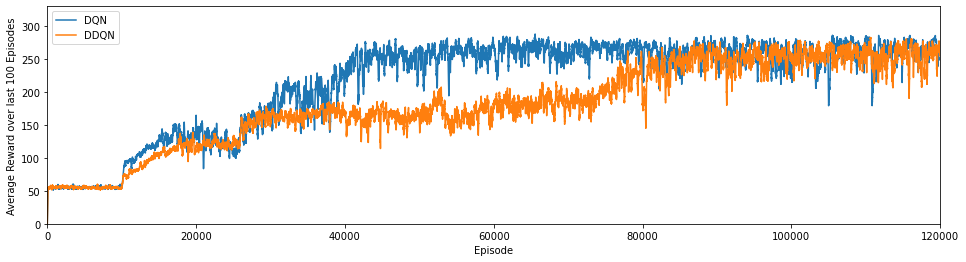

In [87]:
# Plot graph of results.
plt.rcParams['figure.figsize'] = [16, 4]
plt.plot(average_rewards, label="DQN")
plt.plot(average_rewards_DDQN, label="DDQN") 
plt.ylim(0, 330)
plt.xlim(0, NUM_EPISODES)
plt.legend(loc="upper left")
plt.ylabel('Average Reward over last 100 Episodes')
plt.xlabel('Episode')
plt.show()

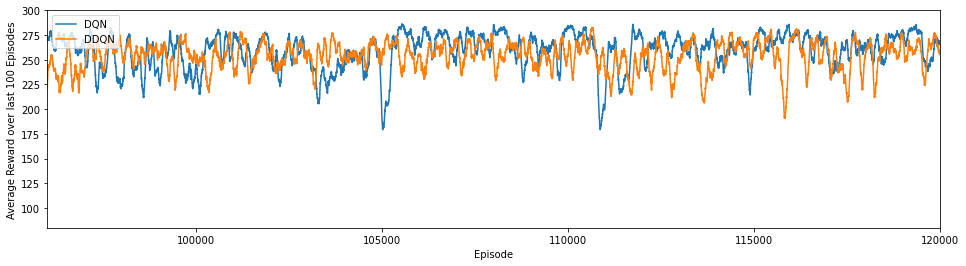

In [86]:
# Zoomed in results
plt.plot(average_rewards, label="DQN")
plt.plot(average_rewards_DDQN, label="DDQN") 
plt.ylim(80, 300)
plt.xlim((NUM_EPISODES/5*4), NUM_EPISODES)
plt.legend(loc="upper left")
plt.ylabel('Average Reward over last 100 Episodes')
plt.xlabel('Episode')
plt.show()